# Lab 3 — recommender systems
**Internet Analytics - Lab 2**

---

**Group:** *K*

**Names:**

* *Robin Lang*
* *Kim Lan Phan Hoang*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pyspark.mllib.recommendation as recomm

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)


In [4]:
from operator import add
movieRating = data.map(lambda d : (d["movieId"], 1)).foldByKey(0, add).collect()

In [5]:
userRating = data.map(lambda d : (d["userId"], 1)).foldByKey(0, add).collect()

## Exercice 3.4

### Plot the number of ratings for each user.

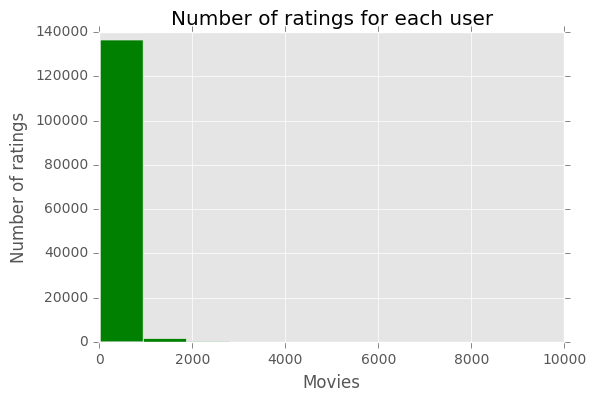

In [6]:
movieRating_val = [x[1] for x in userRating]
plt.hist(movieRating_val, facecolor='green')
plt.title("Number of ratings for each user")
plt.xlabel("Movies")
plt.ylabel("Number of ratings")

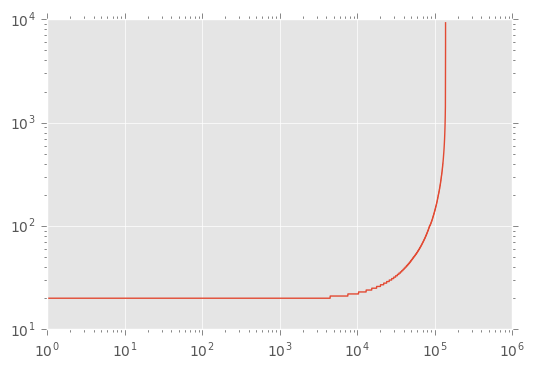

In [7]:
plt.loglog(sorted(movieRating_val))

### Plot the number of ratings for each item.

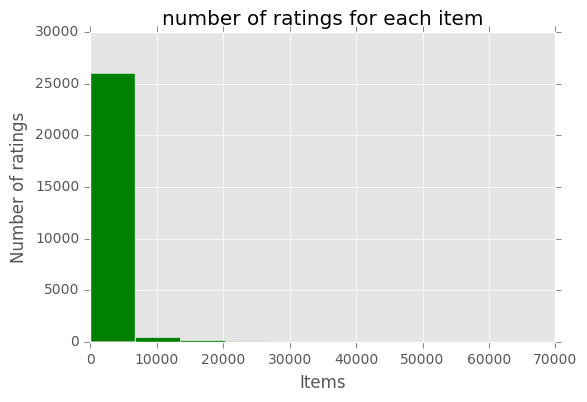

In [8]:
itemRating_val = [x[1] for x in movieRating]
plt.hist(itemRating_val, facecolor='green')
plt.title("number of ratings for each item")
plt.xlabel("Items")
plt.ylabel("Number of ratings")

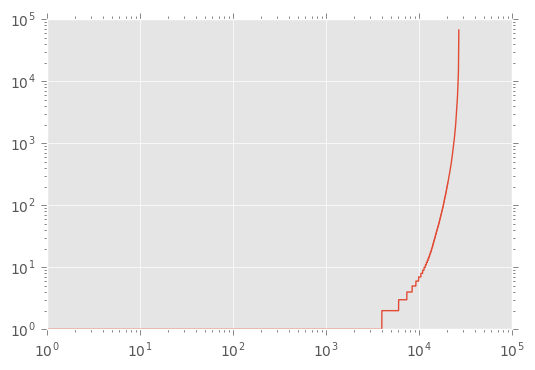

In [9]:
plt.loglog(sorted(itemRating_val))

### Is the number of ratings balanced uniformly across users and movies?

Users have much more ratings than items. Thus items tend to be sparse (but users are also kind of sparse).

## Exercice 3.5

### Append your personal ratings to the MovieLens dataset RDD

In [ ]:
%run -i 'rate-movies.py'
user_id = 138494
#with open("my_ratings.txt") as file:
#    for line in fila:
#        personal_ratings.append(json.loads(line))

### Partition the data into two sets: ~ 80% for training, and ~ 20% for validation

In [10]:
# 20%
def validationSet(x): return (x["timestamp"]% 10) <= 2

# 80%
def trainingSet(x): return not validationSet(x)

validationSetObject = data.filter(validationSet)
trainingSetObject = data.filter(trainingSet)

## Exercice 3.6

### Compute the global mean m, the user biases and the item biases using a sequence of RDD transformations on the training set.

In [11]:
#global average rating mu
def mu(data):
    return data.map(lambda x: x["rating"]).mean()


# user bias alpha_u
def alpha_u(mu_v, data):
    #map : userId, (1, rating - mu)
    #reduceByKey : userid, (1+1, value+value)
    #mapValues : userid, values/nb
    return data.map(lambda x: (x["userId"], (1,x["rating"]-mu_v)))\
            .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))\
            .mapValues(lambda x: x[1]/x[0])


# item bias beta_m
def beta_m(data, mu_v, alpha_values):
    #map : userId, (movieId, rating)
    #join : userId, ((movieId, rating), alpha)
    #map : movieId, (1, rating - alpha - mu)
    #reduceByKey : movieId, (1+1, value+value)
    #mapValues : movieId, values/nb
    return data.map(lambda x: (x["userId"], (x["movieId"], x["rating"])))\
                    .join(alpha_values)\
                    .map(lambda x: (x[1][0][0], (1, x[1][0][1] - x[1][1] - mu_v)))\
                    .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))\
                    .mapValues(lambda x: x[1]/x[0])
    

In [12]:
mu_v = mu(trainingSetObject)
alpha_values = alpha_u(mu_v, trainingSetObject)
beta_values = beta_m(trainingSetObject, mu_v, alpha_values)

In [13]:
alpha_values_mean = alpha_values.map(lambda x: x[1]).mean()
beta_values_mean = beta_values.map(lambda x: x[1]).mean()

In [34]:
print("global mean:   ", mu_v)
print("mean user bias:", alpha_values_mean)
print("mean item bias:", beta_values_mean)

global mean:    3.525640466146785
mean user bias: 0.10154858892500787
mean item bias: -0.20264254821936226


### How many parameters does this model have?

This model has 2 parameters (movie and user).

### Predict the rating of every user / movie pair in the validation set.

In [15]:
#leftouterjoin -> userid , (movieid, alpha) -> may be none
#map : movieid, (userid, alpha)
#leftouterjoin -> movieid, ( (userid, alpha), beta ) -> may be none
#map : (movieid, userid), (mu + alpha + beta)
predictions = validationSetObject.map(lambda x: (x["userId"],x["movieId"]))\
                    .leftOuterJoin(alpha_values)\
                    .map(lambda x: (x[1][0], (x[0], cleanAlpha(x[1][1]))))\
                    .leftOuterJoin(beta_values)\
                    .map(lambda x: ( (x[0],x[1][0][0]), mu_v + x[1][0][1] +  cleanBeta(x[1][1])))

## Exercice 3.7

### Implement a function error() that takes an RDD containing (userId, movieId, rating) triplets and computes the error (3.2) with respect to the validation set. Use this function to evaluate the baseline predictions that you computed previously. You should obtain an error of approximately 0.922.

In [16]:
"""SHOULD BE 0.922"""

# map : (userId, movieId) , rating
# join -> (userId, movieId), (rating, prediction)
# map : userId, (1, (prediction - rating)**2 )
# reducebykey : userId , (1+1 , error2+error2)
# map : sqrt(x1/x0)
# mean                
def error_compute(originalSet, predictions):
    return originalSet.map(lambda x: ((x[0],x[1]),x[2]))\
                 .join(predictions)\
                 .map(lambda x : (x[0][0],(1, (x[1][1]-x[1][0])**2)))\
                 .reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]))\
                 .map(lambda x: np.sqrt(x[1][1]/x[1][0]))\
                .mean()

In [17]:
set_for_error = validationSetObject.map(lambda x: (x['userId'], x['movieId'], x['rating'])).persist()

In [18]:
error_compute(set_for_error, predictions)

1.0436775410097952

## Exercice 3.8

### What is the trade-off between choosing a lower and a higher rank?

Choosing a lower rank will lead to overgeneralizing, which won't be precize enough.
while choosing a higher rank might lead to overfitting, giving us something way more complex than wanted.

In [ ]:
setObj = trainingSetObject.map(lambda x: (x['userId'], x['movieId'], x['rating'])).persist()
validationOriginalSet = trainingSetObject.map(lambda x: (x['userId'], x['movieId'], x['rating'])).persist()
valObj = validationSetObject.map(lambda x: (x['userId'], x['movieId'])).persist()

rank = 10

In [ ]:
def getModel(lambda_v):
    return recomm.ALS.train(setObj, rank, lambda_=lambda_v)

def recommendation_error(lambda_v):
    model = getModel(lambda_v)
    predictions = model.predictAll(valObj)
    prediction_formated = predictions.map(lambda r: ((r.product, r.user),r.rating))
    return error_compute(validationOriginalSet,prediction_formated)

### How accurate are the predicted ratings? Can you explain the phenomenon? (lambda = 1e-4)

In our case, these predicted ratings are not really better than the ones we get earlier.

In [ ]:
recommendation_error(1e-4)

### What happens to the predicted ratings, and why? (lambda = 10)

This case is even worse. The lambda parameter is too high to provide an accurate result. There exists a good range of lambda to choose to obtain minimal error values (see the graph below).

In [ ]:
"""DONT WANT TO COMPUTE FOR MORE THAN 1"""
print(recommendation_error(0.9))

### Find the value of lambda_ that minimizes the validation error.

We choose the value of lambda whose error is the smallest. 

In [ ]:
lambda_values = [1e-4, 2.5*1e-4, 5*1e-4, 7.5*1e-4, 1e-3]
res = []
for l in lambda_values:
    res.append(recommendation_error(lambda_v = l))

In [ ]:
plt.plot(lambda_values, res)
plt.show()

In [ ]:
lambda_values = [1e-3, 2.5*1e-2, 5*1e-2, 7.5*1e-2, 1e-2]
res = []
for l in lambda_values:
    res.append(recommendation_error(lambda_v = l))
    
plt.plot(lambda_values, res)
plt.show()

### What improvement do you get over the error of the baseline recommender system?

ROBIIIIIIIIIIIIIN

In [ ]:
best_lambda = 0.01

## Exercice 3.9

In [ ]:
# obtain movies data
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads).map(lambda x: (x["movieId"],(x["title"],x["genres"])))

### Recommend 10 movies for user 123 using model.recommendProducts(). What kind of movies does the model think the user will like?

In [ ]:
# model to recommand movies
model = getModel(best_lambda)

In [ ]:
recomm123 = model.recommendProducts(123,10)
sc.parallelize(recomm123).map(lambda r : (r.product, r.user)).join(movies).map(lambda x: x[1][1]).collect()

The system recommends mostly drama genre movies.

### Recommend 10 movies to yourself (user ID: 138494). What do you think of your recommendations?

In [ ]:
recomm138494 = model.recommendProducts(138494,10)
sc.parallelize(recomm138494).map(lambda r : (r.product, r.user)).join(movies).map(lambda x: x[1][1]).collect()

## Exercice 3.10

### Extract the features for all the movies in selected-movies.pickle.

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()
import pickle

In [ ]:
rank = 2
model2 = getModel(best_lambda)

In [ ]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    

In [ ]:
projected_x = [] # first principal direction
projected_y = [] # second principal direction

for i in movies:
    projected_x.append(np.dot(relevance_array_load.T[i[0]-1], rel_dirs[0]))
    projected_y.append(np.dot(relevance_array_load.T[i[0]-1], rel_dirs[1]))

In [ ]:
# Continuous colors
from matplotlib.colors import rgb2hex 

# colors:   0% -> red
#          50% -> yellow
#         100% -> green
# interpolated in between
def rottenColor(val):
    if val<0.5:
        return rgb2hex([1.0, 2*val, 0.0])
    else:
        return rgb2hex([2*(1.0-val), 1.0, 0.0])

source = ColumnDataSource(
    data={
        "x": projected_x,
        "y": projected_y,
        "name": [x[1] for x in movies],
        "color": [rottenColor(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=960, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=1.0)
show(p, notebook_handle=True)

### Create an interactive plot that embeds the movies along the 2 directions defined by the factorization

### Describe what you observe. Can you give a name to the dimensions? Do you recognize cluster of movies that are alike?